### Import libraries

In [2]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging
import platform

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2.14.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3320934367946136186
xla_global_id: -1
]


In [4]:
# Import other libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from random import seed
from random import randint
seed(1)

### Data inspection

In [11]:
# Load the data from the file
file_path = 'cleaned_data_augmented.npz'
loaded_data = np.load(file_path, allow_pickle=True)

# Put data into proper arrays
data = loaded_data['data']
labels = loaded_data['labels']

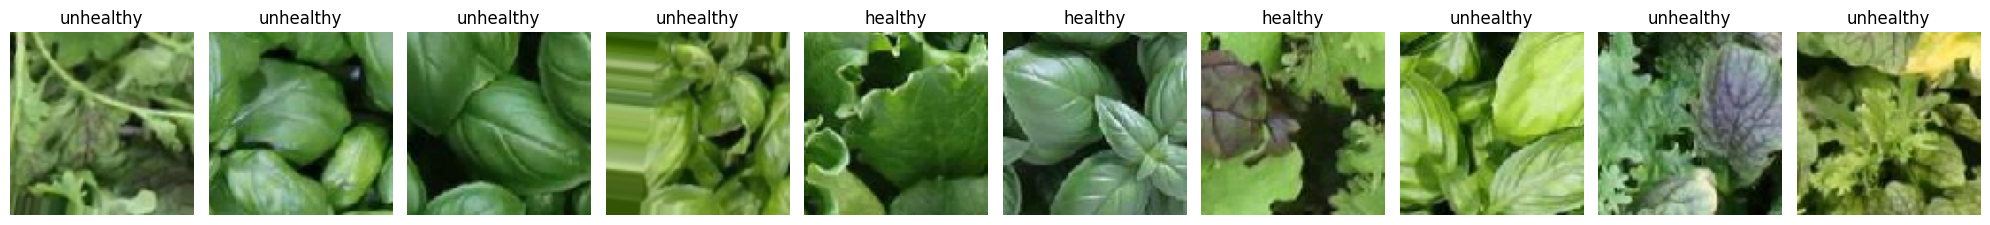

In [12]:
# Number of images to display
num_img = 10

# Create subplots for displaying 10 random items from the dataset
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))
for i in range(num_img):
    value = randint(0, len(data))
    ax = axes[i%num_img]
    ax.imshow(data[value].astype(np.uint8), cmap = 'gray')
    label = labels[value]
    ax.set_title(f'{labels[value]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Prepare data

In [13]:
healthy = []
unhealthy = []

# Iterate through the images to separate them in the proper set
for i, image in enumerate(data):
    if (labels[i] == 'unhealthy'):
        unhealthy.append(image)
    else:
        healthy.append(image)

print(len(healthy))
print(len(unhealthy))


3060
3070


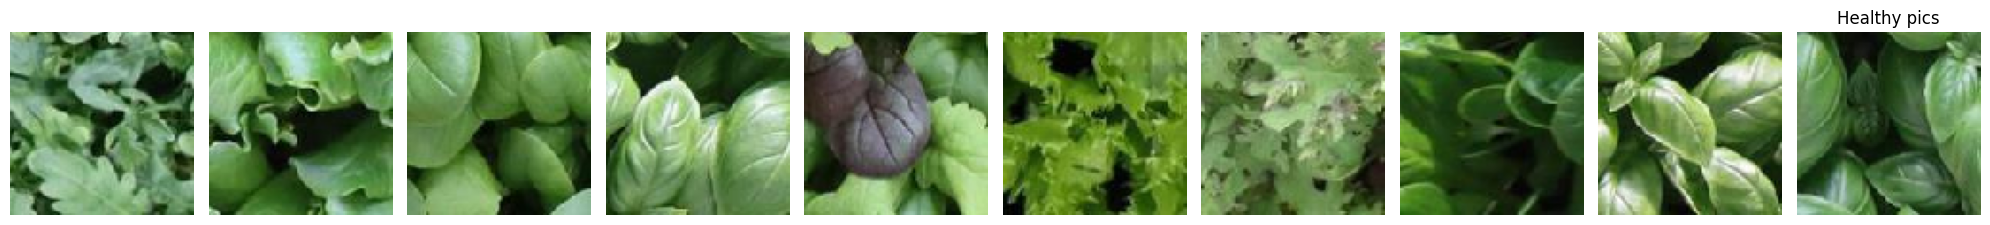

In [14]:
## CAN BE SKIPPED ##

# Number of images to display
num_img = 10

# Create subplots for displaying 10 healthy pics
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))
plt.title("Healthy pics") 
for i in range(num_img):
    value = randint(0, len(healthy))
    ax = axes[i%num_img]
    ax.imshow(healthy[value].astype(np.uint8), cmap = 'gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

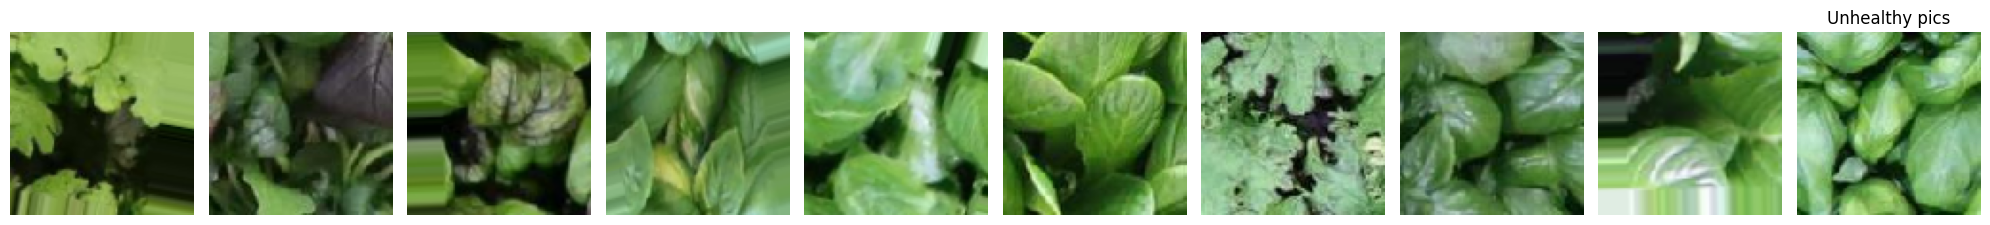

In [15]:
## CAN BE SKIPPED ##

# Number of images to display
num_img = 10

# Create subplots for displaying 10 random unhealthy pics
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))
plt.title("Unhealthy pics") 
for i in range(num_img):
    value = randint(0, len(unhealthy))
    ax = axes[i%num_img]
    ax.imshow(unhealthy[value].astype(np.uint8), cmap = 'gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [23]:
# Fix randomness and hide warnings
seed = 42

#Concatenate 'healthy' and 'unhealthy'
x = np.concatenate([healthy, unhealthy], axis = 0)

# Create labels: 0 for 'healthy', 1 for 'unhealthy'
y = np.concatenate([np.ones(len(healthy)), np.zeros(len(unhealthy))], axis = 0)
y = tfk.utils.to_categorical(y, len(np.unique(y)))

# Split data into train_val and test sets
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, random_state=seed, test_size=.125, stratify=np.argmax(y, axis=1))

# Further split train_val into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=seed, test_size=len(x_test), stratify=np.argmax(y_train_val, axis=1))

# Print shapes of the datasets
print(f"X_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (4596, 96, 96, 3), y_train shape: (4596, 2)
X_val shape: (767, 96, 96, 3), y_val shape: (767, 2)
X_test shape: (767, 96, 96, 3), y_test shape: (767, 2)


reminder **need to do image augmentation on unhealthy set which is clearly outnumbered**.

In [24]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = x_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 100

img_height = 96
img_width = 96

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

Input Shape: (96, 96, 3), Output Shape: (2,), Batch Size: 32, Epochs: 100


In [25]:
# Tells the model when to stop if values do not change
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True, mode='auto'),
]

### Train the model

In [26]:
# Build the model sequentially
import platform

def build_model(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters = 32,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    ) (input_layer)
    pool1 = tfkl.MaxPooling2D() (conv1)

    conv2 = tfkl.Conv2D(
        filters = 64,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    ) (pool1)
    pool2 = tfkl.MaxPooling2D() (conv2)

    conv3 = tfkl.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    ) (pool2)
    pool3 = tfkl.MaxPooling2D() (conv3)
    
    conv4 = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    ) (pool3)
    pool4 = tfkl.MaxPooling2D() (conv4)
    
    conv5 = tfkl.Conv2D(
        filters = 512,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    ) (pool4)
    pool5 = tfkl.MaxPooling2D() (conv5)
    
    gap_layer = tfkl.GlobalAveragePooling2D (name = 'Gap') (pool5)
    dropout = tfkl.Dropout(0.3, seed = seed) (gap_layer)


    output_layer = tfkl.Dense(
        units = 2,
        activation = 'softmax',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'output_layer',
        kernel_regularizer = tf.keras.regularizers.L1L2(0.005)
    ) (dropout)

    # Connect input and output through the Model class
    model = tfk.Model(
        inputs = input_layer, 
        outputs = output_layer, 
        name = 'model')

    # Compile the model
    model.compile(
        loss = tfk.losses.CategoricalCrossentropy(), 
        optimizer = tfk.optimizers.Adam(), 
        metrics = ['accuracy'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 128)       73856 

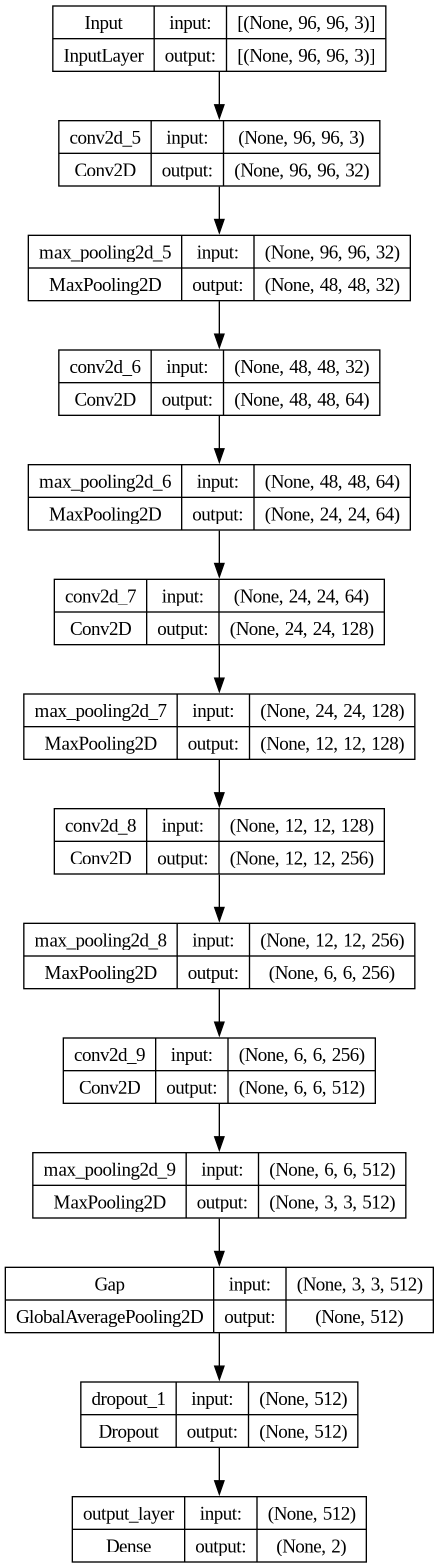

In [27]:
# Build the model and return a summary about it
model = build_model()
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [28]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_val, y_val),
    callbacks = callbacks
).history

Epoch 1/100
144/144 [==============================] - 30s 202ms/step - loss: 31.8057 - accuracy: 0.5279 - val_loss: 0.9571 - val_accuracy: 0.5541
Epoch 2/100
144/144 [==============================] - 30s 208ms/step - loss: 0.9395 - accuracy: 0.5886 - val_loss: 0.9309 - val_accuracy: 0.5632
Epoch 3/100
144/144 [==============================] - 30s 206ms/step - loss: 0.9059 - accuracy: 0.6332 - val_loss: 0.9305 - val_accuracy: 0.5880
Epoch 4/100
144/144 [==============================] - 30s 210ms/step - loss: 0.8781 - accuracy: 0.6573 - val_loss: 0.9415 - val_accuracy: 0.5854
Epoch 5/100
144/144 [==============================] - 30s 207ms/step - loss: 0.8475 - accuracy: 0.6758 - val_loss: 0.9134 - val_accuracy: 0.6167
Epoch 6/100
144/144 [==============================] - 30s 207ms/step - loss: 0.8181 - accuracy: 0.7082 - val_loss: 0.8570 - val_accuracy: 0.6675
Epoch 7/100
144/144 [==============================] - 30s 207ms/step - loss: 0.7827 - accuracy: 0.7315 - val_loss: 0.8592 

### Save the model and create submission

In [29]:
# Save model
import os
from datetime import datetime

SUBMISSION_DIR = f'submission-{datetime.today().strftime("%Y-%m-%d-%H-%M-%S")}'
os.mkdir(SUBMISSION_DIR)

with open(os.path.join(SUBMISSION_DIR, "metadata"), "a") as f:
  pass

import shutil

model.save(SUBMISSION_DIR + '/SubmissionModel')
shutil.make_archive(SUBMISSION_DIR, 'zip', SUBMISSION_DIR)

'/home/martina/ve/ANN1/submission-2023-11-11-20-39-26.zip'

### Plots

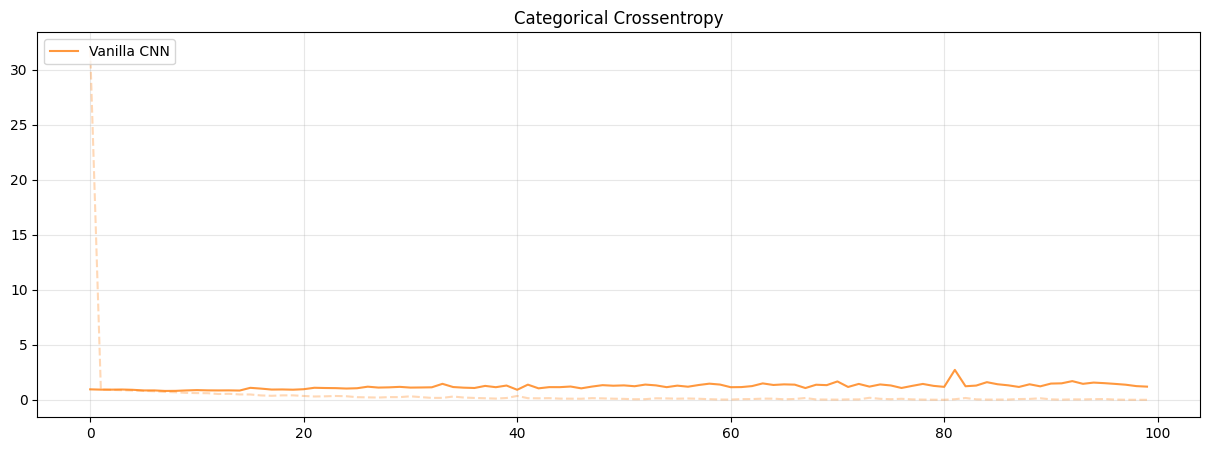

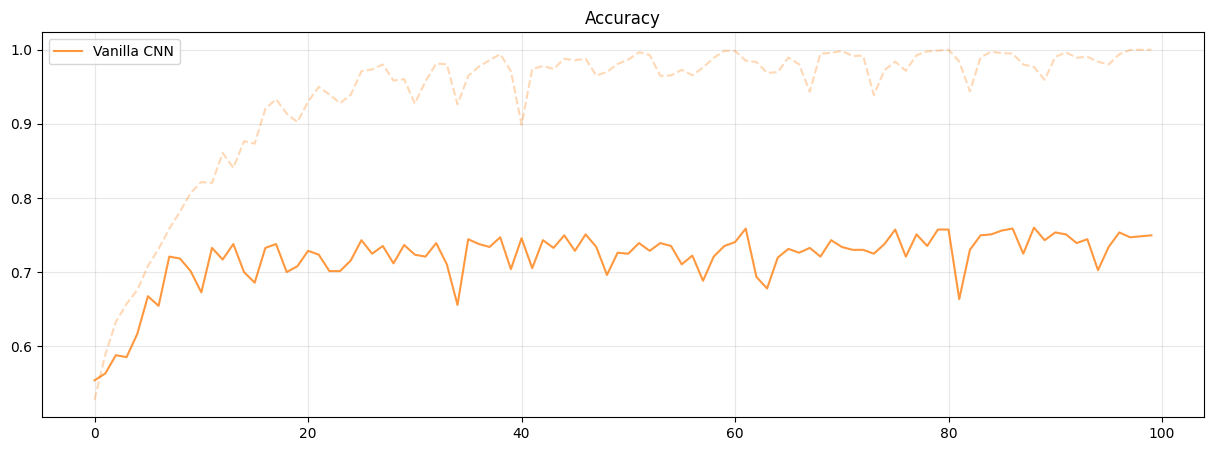

In [30]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

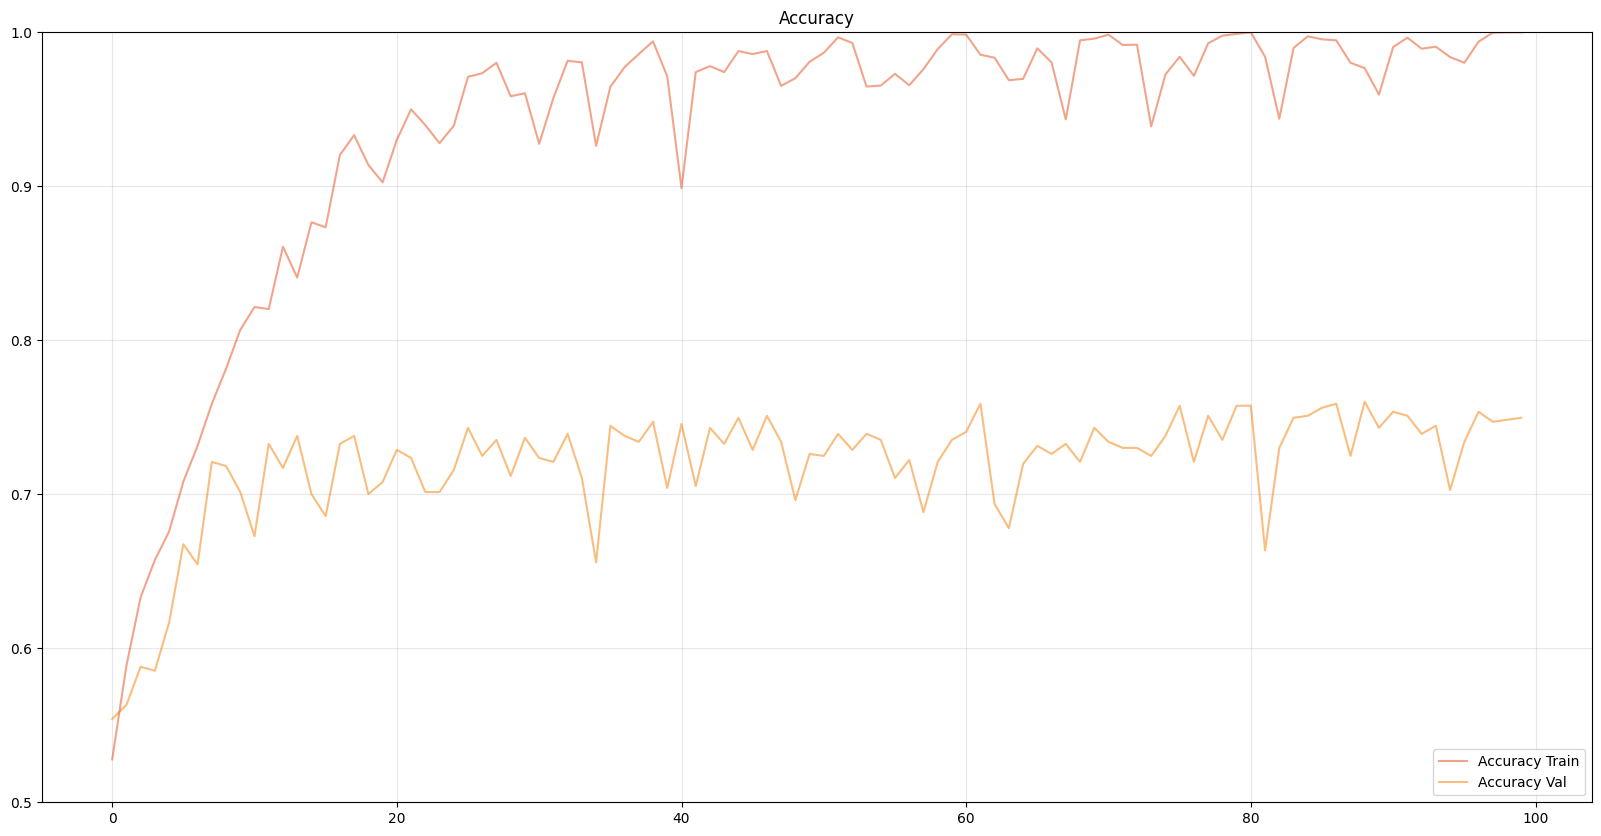

In [31]:
# Plot accuracy graph

plt.figure(figsize=(20,10))

ALPHA = 0.5
 
plt.plot(history['accuracy'], label='Accuracy Train', alpha=ALPHA, color='#E64A19') 
plt.plot(history['val_accuracy'], label='Accuracy Val', alpha=ALPHA, color='#F57C00') 
 
plt.ylim(.5, 1) 
plt.title('Accuracy') 
plt.legend(loc='lower right') 
plt.grid(alpha=.3) 
plt.show()